# 1. Setting up the enviroment

## Imports

In [1]:
import os

import IPython.display as ipd
from IPython.display import clear_output

import librosa as librosa
import librosa.display as display

import numpy as np
import matplotlib.pyplot as plt
import scipy

## Global variables

In [13]:
#artist
artist = "birds"

#sampling rate
sr = 22050

#min freq 
fmin = 20

#max freq
fmax = sr / 2 

#number of samples. 
#for music it is recommended 2048, but with 4096 we are getting better results
n_fft = 4096

#(columns) - so we can get 128 frames 
hop_length = 690

#(rows) - With this, we get nice 128 x 128 spectrograms 
n_mels = 128

#folder where the wav files are stored
wav_folder_name='data/wav/{}/'.format(artist)

#filename
wav_filename = 'birds_cornell'

# 2. Helpers

## List with all the wav files in a folder

In [14]:
def get_file_list(base_folder, extension='wav'):
    
    file_list = os.listdir(base_folder)
    file_list_filtered = []
    
    for filename in file_list:
        if filename.endswith("." + extension):
            full_filename = base_folder + filename
            file_list_filtered.append(full_filename)
    
    return sorted(file_list_filtered)

## Array with all the 128 x 128 raw mel spectrograms

In [15]:
def get_features(file_list, sr=22050, n_fft=1024, hop_length=512, n_mels=20, stop_at=0, show_info=True, fmin=0, fmax=8000):
    
    file_counter = len(file_list) if stop_at<=0 else min(stop_at, len(file_list))
    first_run = True
    mel_spectrogram_array = []  
    
    for file_index in range(file_counter):
        
        y, _ = librosa.load(file_list[file_index])
        mel_spectrogram = librosa.feature.melspectrogram(y, n_mels=n_mels, sr=sr, 
                                                         n_fft=n_fft, hop_length=hop_length, 
                                                         window=scipy.signal.hamming,
                                                         fmin=fmin, fmax=fmax)
        if first_run:
            n_frames = mel_spectrogram.shape[1]
            mel_spectrogram_array = np.empty((file_counter,n_mels,n_frames))  
            first_run = False

        mel_spectrogram_array[file_index] = mel_spectrogram
        
        if (file_index % 100 == 99):
            print(file_index+1, "/", file_counter, " audio clips processed", sep='')
            clear_output(wait=True)
    
    if show_info:
        print ("Mel shape:", mel_spectrogram.shape)
        print ("Mel - Min:", np.amin(mel_spectrogram_array), "Max:", np.amax(mel_spectrogram_array))
        
    return n_frames, mel_spectrogram_array

# 3. Generate and save spectrograms

In [16]:
file_list = get_file_list(wav_folder_name)

In [17]:
n_frames, mel_array = get_features(file_list, sr=sr, 
                                   n_fft=n_fft, hop_length=hop_length, 
                                   n_mels=n_mels,
                                   fmin=fmin, fmax=fmax)

Mel shape: (128, 128)
Mel - Min: 0.0 Max: 3636.8232421875


# 4. Generate and save images

In [19]:
mel_counter = len(mel_array) 

for image_index in range(mel_counter):
    mel = mel_array[image_index]
    mel_db = librosa.power_to_db(mel, ref=np.max)
    plt.imsave("data/spectrograms/{}/{}_{:06d}.png".format(artist, wav_filename, image_index), mel_db, cmap='binary', origin='lower')
    if (image_index % 100 == 99):
        print(image_index+1, "/", mel_counter, " spectrograms processed", sep='')
        clear_output(wait=True)

9000/9071 spectrograms processed


# 5. Sanity check

In [22]:
element = np.random.randint(0,len(mel_array))

## Image to audio

In [23]:
mel_img = plt.imread("spectrograms/{}_{:06d}.png".format(artist,element))
mel_img = mel_img[:,:,0]
mel_img = np.flip(mel_img, axis=0)
mel_img = -mel_img*80

mel_img_power = librosa.db_to_power(mel_img)

Text(0.5, 1.0, 'dB - >Power (from img)')

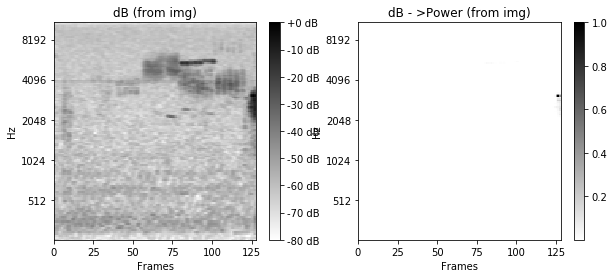

In [24]:
plt.figure(figsize=[10,4])

plt.subplot(1, 2, 1)
librosa.display.specshow(mel_img, 
                         x_axis='frames', y_axis='mel', cmap='binary',
                         fmin=fmin, fmax=fmax)
plt.colorbar(format='%+2.0f dB')
plt.title('dB (from img)')

plt.subplot(1, 2, 2)
librosa.display.specshow(mel_img_power, 
                         x_axis='frames', y_axis='mel', cmap='binary',
                         fmin=fmin, fmax=fmax)
plt.colorbar()
plt.title('dB - >Power (from img)')



In [26]:
y_from_mel_img_power = librosa.feature.inverse.mel_to_audio(mel_img_power, sr=sr, 
                                                  n_fft=n_fft, hop_length=hop_length, 
                                                  window=scipy.signal.hamming,
                                                  fmin=fmin, fmax=fmax)
ipd.Audio(y_from_mel_img_power, rate=sr)